# (21) NVAE — play

**Motivation**: Play around with the official implementation and figure it out. <br>

In [1]:
# HIDE CODE


import os, sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

sys.path.insert(0, pjoin(git_dir, '[git-cloned]', 'NVAE'))
import utils

In [2]:
# HIDE CODE


import re
import os
import json
import h5py
import torch
import pickle
import joblib
import shutil
import random
import pathlib
import inspect
import logging
import argparse
import warnings
import operator
import functools
import itertools
import collections
import numpy as np
import pandas as pd
from tqdm import tqdm
from rich import print
from datetime import datetime
from os.path import join as pjoin
from prettytable import PrettyTable
from scipy import linalg as sp_lin
from scipy import signal as sp_sig
from scipy import stats as sp_stats
from scipy import ndimage as sp_img
from scipy.spatial import distance as sp_dist
from sklearn.preprocessing import Normalizer
from numpy.ma import masked_where as mwh
from typing import *
import torch
from torch import nn


def print_num_params(module: nn.Module):
    t = PrettyTable(['Module Name', 'Num Params'])

    for name, m in module.named_modules():
        total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
        x = total_params // 1e6
        y = total_params // 1e3
        if x > 0:
            num = f"{np.round(total_params / 1e6, 2):1.1f} M"
        elif y > 0:
            num = f"{np.round(total_params / 1e3, 2):1.1f} K"
        else:
            num = total_params

        if '.' not in name:
            if isinstance(m, type(module)):
                t.add_row(["{}".format(m.__class__.__name__), "{}".format(num)])
                t.add_row(['---', '---'])
            else:
                t.add_row([name, "{}".format(num)])
    print(t, '\n\n')

In [3]:
# HIDE CODE


ArgsNVAE = collections.namedtuple(
    typename='args',
    field_names=[
        'data',
        'dataset',
        'batch_size',
        'learning_rate',
        'learning_rate_min',
        'weight_decay',
        'weight_decay_norm',
        'weight_decay_norm_init',
        'weight_decay_norm_anneal',
        'epochs',
        'warmup_epochs',
        'fast_adamax',
        'arch_instance',
        'kl_anneal_portion',
        'kl_const_portion',
        'kl_const_coeff',
        'num_nf',
        'num_x_bits',
        'num_latent_scales',
        'num_groups_per_scale',
        'num_latent_per_group',
        'ada_groups',
        'min_groups_per_scale',
        'num_channels_enc',
        'num_preprocess_blocks',
        'num_preprocess_cells',
        'num_cell_per_cond_enc',
        'num_channels_dec',
        'num_postprocess_blocks',
        'num_postprocess_cells',
        'num_cell_per_cond_dec',
        'num_mixture_dec',
        'num_total_iter',
        'master_address',
        'local_rank',
        'use_se',
        'res_dist',
        'cont_training',
        'distributed',
    ])

args_default = {
    'data': tmp_dir,
    'dataset': 'mnist',
    'batch_size': 200,
    'learning_rate': 1e-2,
    'learning_rate_min': 1e-4,
    'weight_decay': 3e-4,
    'weight_decay_norm': 0,
    'weight_decay_norm_init': 10,
    'weight_decay_norm_anneal': False,
    'epochs': 200,
    'warmup_epochs': 5,
    'fast_adamax': False,
    'arch_instance': 'res_mbconv',
    'kl_anneal_portion': 0.3,
    'kl_const_portion': 0.0001,
    'kl_const_coeff': 0.0001,
    'num_nf': 0,
    'num_x_bits': 8,
    'num_latent_scales': 1,
    'num_groups_per_scale': 10,
    'num_latent_per_group': 20,
    'ada_groups': False,
    'min_groups_per_scale': 1,
    'num_channels_enc': 32,
    'num_preprocess_blocks': 2,
    'num_preprocess_cells': 3,
    'num_cell_per_cond_enc': 1,
    'num_channels_dec': 32,
    'num_postprocess_blocks': 2,
    'num_postprocess_cells': 3,
    'num_cell_per_cond_dec': 1,
    'num_mixture_dec': 10,
    'num_total_iter': 120000,
    'master_address': '126.0.0.1',
    'local_rank': 0,
    'use_se': False,
    'res_dist': False,
    'cont_training': False,
    'distributed': False,
}

In [4]:
args_cifar = args_default.copy()

# Normal Decoder
args_cifar['num_mixture_dec'] = 1

args_cifar['dataset'] = 'cifar10'
args_cifar['num_channels_enc'] = 128
args_cifar['num_channels_dec'] = 128
args_cifar['num_postprocess_cells'] = 2
args_cifar['num_preprocess_cells'] = 2
args_cifar['num_latent_scales'] = 1
args_cifar['num_latent_per_group'] = 20
args_cifar['num_cell_per_cond_enc'] = 2
args_cifar['num_cell_per_cond_dec'] = 2
args_cifar['num_preprocess_blocks'] = 1
args_cifar['num_postprocess_blocks'] = 1
args_cifar['num_groups_per_scale'] = 30
args_cifar['num_nf'] = 1
args_cifar['min_groups_per_scale'] = 4
args_cifar['weight_decay_norm'] = 1e-2
args_cifar['use_se'] = True
args_cifar['res_dist'] = True
args_cifar['ada_groups'] = True
args_cifar['fast_adamax'] = True
args_cifar['batch_size'] = 32
args_cifar['epochs'] = 400

args_cifar = ArgsNVAE(**args_cifar)

In [5]:
arch_instance = utils.get_arch_cells(args_cifar.arch_instance)
arch_instance

{'normal_enc': ['res_bnswish', 'res_bnswish'],
 'down_enc': ['res_bnswish', 'res_bnswish'],
 'normal_dec': ['mconv_e6k5g0'],
 'up_dec': ['mconv_e6k5g0'],
 'normal_pre': ['res_bnswish', 'res_bnswish'],
 'down_pre': ['res_bnswish', 'res_bnswish'],
 'normal_post': ['mconv_e3k5g0'],
 'up_post': ['mconv_e3k5g0'],
 'ar_nn': ['']}

In [6]:
from model import AutoEncoder
model = AutoEncoder(args_cifar, None, utils.get_arch_cells(args_cifar.arch_instance))
# mnist = mnist.cuda()

len log norm: 610
len bn: 364


In [7]:
print_num_params(model)

+-------------------+------------+
|    Module Name    | Num Params |
+-------------------+------------+
|    AutoEncoder    |  130.7 M   |
|        ---        |    ---     |
|        stem       |   3.7 K    |
|    pre_process    |   1.2 M    |
|     enc_tower     |   73.3 M   |
|        enc0       |   66.0 K   |
|    enc_sampler    |   2.8 M    |
|    dec_sampler    |  299.3 K   |
|      nf_cells     |   1.6 M    |
|       enc_kv      |     0      |
|       dec_kv      |     0      |
|       query       |     0      |
|     dec_tower     |   50.9 M   |
|    post_process   |  465.2 K   |
| image_conditional |   6.9 K    |
+-------------------+------------+

In [8]:
args_cifar.num_mixture_dec, args_cifar.distributed

(1, False)

In [9]:
model.image_conditional

Sequential(
  (0): ELU(alpha=1.0)
  (1): Conv2D(128, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [10]:
import utils
import datasets
utils, datasets

(<module 'utils' from '/home/hadi/Dropbox/git/[git-cloned]/NVAE/utils.py'>,
 <module 'datasets' from '/home/hadi/Dropbox/git/[git-cloned]/NVAE/datasets.py'>)

In [11]:
# train_queue, valid_queue, num_classes = datasets.get_loaders(args_cifar)

100%|███████████████████████| 170498071/170498071 [00:04<00:00, 38085175.99it/s]


Extracting /home/hadi/Dropbox/git/jb-MTMST/tmp/cifar-10-python.tar.gz to /home/hadi/Dropbox/git/jb-MTMST/tmp
Files already downloaded and verified


In [26]:
alpha_i = utils.kl_balancer_coeff(
    num_scales=mnist.num_latent_scales,
    groups_per_scale=mnist.groups_per_scale, fun='square')
alpha_i = alpha_i.cpu()
alpha_i

tensor([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [27]:
global_step = 120

In [28]:
%%time

for step, x in enumerate(train_queue):
    x = x[0] if len(x) > 1 else x
    x = utils.pre_process(x, args_mnist.num_x_bits)
    with torch.cuda.amp.autocast():
        logits, log_q, log_p, kl_all, kl_diag = mnist(x)
        output = mnist.decoder_output(logits)
        kl_coeff = utils.kl_coeff(global_step, args_mnist.kl_anneal_portion * args_mnist.num_total_iter,
                                  args_mnist.kl_const_portion * args_mnist.num_total_iter, args_mnist.kl_const_coeff)
        recon_loss = utils.reconstruction_loss(output, x, crop=mnist.crop_output)
        balanced_kl, kl_coeffs, kl_vals = utils.kl_balancer(kl_all, kl_coeff, kl_balance=True, alpha_i=alpha_i)
        nelbo_batch = recon_loss + balanced_kl
        loss = torch.mean(nelbo_batch)
    break

CPU times: user 8min 21s, sys: 1min 9s, total: 9min 31s
Wall time: 1min 6s


In [31]:
balanced_kl.size()

torch.Size([200])

In [32]:
recon_loss.size()

torch.Size([200])

In [33]:
nelbo_batch.size()

torch.Size([200])

In [34]:
loss

tensor(534.0467, grad_fn=<MeanBackward0>)

In [ ]:
def do():
    for step, x in enumerate(train_queue):
        x = x[0] if len(x) > 1 else x
        x = x.cuda()
        x = utils.pre_process(x, args_mnist.num_x_bits)
        with torch.cuda.amp.autocast():
            logits, log_q, log_p, kl_all, kl_diag = mnist(x)
            output = model.decoder_output(logits)
        break
    return logits, output

In [36]:
warmup_iters = len(train_queue) * args_mnist.warmup_epochs

In [37]:
args_mnist.epochs, args_mnist.warmup_epochs

(400, 5)

tensor([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       device='cuda:0')

In [39]:
nelbo = utils.AvgrageMeter()
mnist.train();

In [40]:
def init_processes(rank, size, fn, args):
    """ Initialize the distributed environment. """
    os.environ['MASTER_ADDR'] = args.master_address
    os.environ['MASTER_PORT'] = '6020'
    torch.cuda.set_device(args.local_rank)
    torch.distributed.init_process_group(backend='nccl', init_method='env://', rank=rank, world_size=size)
    fn(args)
    cleanup()


def cleanup():
    torch.distributed.destroy_process_group()

In [42]:
init_processes(0, 1, do, args_mnist)

AttributeError: 'args' object has no attribute 'local_rank'

In [63]:
logits, log_q, log_p, kl_all, kl_diag = mnist(x)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [52]:
x.shape

torch.Size([200, 1, 32, 32])

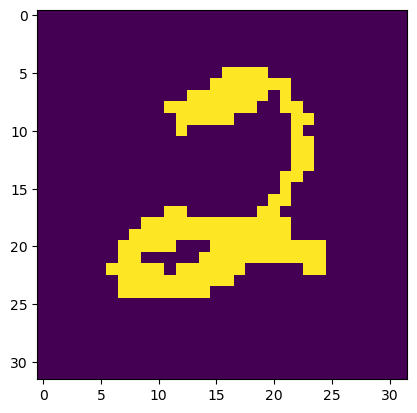

In [61]:
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

plt.imshow(x.data.cpu()[10, 0])
plt.show()

In [40]:
a = mnist.dec_tower[29]._ops[0].conv[3]
print(a)

Conv2D(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [41]:
print(a.log_weight_norm)

None

In [42]:
def norm(t, dim):
    return torch.sqrt(torch.sum(t * t, dim))

In [36]:
a.weight.shape

torch.Size([128, 768, 1, 1])

In [80]:
class Conv2D(nn.Conv2d):
    def __init__(self, normalize: bool = True, **kwargs):
        print(kwargs)
        super(Conv2D, self).__init__(**kwargs)

In [84]:
kkk = {
    'normalize': True,
    'in_channels': 42,
    'out_channels': 15,
    'kernel_size': 1,
    'stride': 2,
    'padding': 0,
    'bias': True,
}

In [85]:
aaa = Conv2D(**kkk)

{
    'in_channels': 42,
    'out_channels': 15,
    'kernel_size': 1,
    'stride': 2,
    'padding': 0,
    'bias': True
}

In [ ]:
    cnn_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        cnn_optimizer, float(args.epochs - args.warmup_epochs - 1), eta_min=args.learning_rate_min)

In [87]:
float(args_mnist.epochs - args.warmup_epochs - 1)

394.0

In [88]:
args_mnist.epochs, args.warmup_epochs

(400, 5)

In [89]:
args_mnist.weight_decay

0.0003

In [90]:
args_mnist.learning_rate

0.01

In [91]:
torch.abs

<function torch._VariableFunctionsClass.abs>

In [50]:
b = mnist.pre_process[2]._ops[0].conv_0
print(b)

Conv2D(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [52]:
print(b.log_weight_norm.shape)

torch.Size([64, 1, 1, 1])

In [65]:
b_weight_norm = norm(b.weight, [1, 2, 3])
b_weight_norm

tensor([0.5922, 0.5541, 0.5885, 0.5837, 0.5935, 0.5634, 0.5676, 0.5712, 0.5839,
        0.6095, 0.5787, 0.5781, 0.5648, 0.5865, 0.5374, 0.5805, 0.5578, 0.5730,
        0.5428, 0.5913, 0.5931, 0.5611, 0.5556, 0.5787, 0.5779, 0.5770, 0.5504,
        0.5731, 0.5946, 0.5477, 0.5598, 0.5899, 0.5690, 0.5881, 0.6004, 0.5720,
        0.5774, 0.5895, 0.5261, 0.5827, 0.5701, 0.5747, 0.5782, 0.5778, 0.5752,
        0.5675, 0.5588, 0.5683, 0.5836, 0.5694, 0.5856, 0.5580, 0.5636, 0.5871,
        0.5825, 0.5845, 0.5875, 0.5845, 0.5914, 0.5781, 0.5621, 0.5748, 0.5765,
        0.5632], grad_fn=<SqrtBackward0>)

In [66]:
torch.linalg.vector_norm(b.weight, dim=[1, 2, 3])

tensor([0.5922, 0.5541, 0.5885, 0.5837, 0.5935, 0.5634, 0.5676, 0.5712, 0.5839,
        0.6095, 0.5787, 0.5781, 0.5648, 0.5865, 0.5374, 0.5805, 0.5578, 0.5730,
        0.5428, 0.5913, 0.5931, 0.5611, 0.5556, 0.5787, 0.5779, 0.5770, 0.5504,
        0.5731, 0.5946, 0.5477, 0.5598, 0.5899, 0.5690, 0.5881, 0.6004, 0.5720,
        0.5774, 0.5895, 0.5261, 0.5827, 0.5701, 0.5747, 0.5782, 0.5778, 0.5752,
        0.5675, 0.5588, 0.5683, 0.5836, 0.5694, 0.5856, 0.5580, 0.5636, 0.5871,
        0.5825, 0.5845, 0.5875, 0.5845, 0.5914, 0.5781, 0.5621, 0.5748, 0.5765,
        0.5632], grad_fn=<LinalgVectorNormBackward0>)

In [ ]:
torch.norm()

In [69]:
def norm(t, dim):
    return torch.sqrt(torch.sum(t * t, dim))



def normalize_weight_jit(log_weight_norm, weight):
    n = torch.exp(log_weight_norm)
    wn = torch.linalg.vector_norm(weight, dim=[1, 2, 3])
    weight = n * weight / (wn.view(-1, 1, 1, 1) + 1e-6)
    return weight



class Conv2D(nn.Conv2d):
    def __init__(self, C_in, C_out, kernel_size, stride=1, padding=0, dilation=1, groups=1,
                 bias=False, normalize_weight=True):
        super(Conv2D, self).__init__(C_in, C_out, kernel_size, stride, padding, dilation, groups, bias)

        self.normalize_weight = normalize_weight
        if weight_norm:
            init = torch.linalg.vector_norm(self.weight, dim=[1, 2, 3], keepdim=True)
            self.log_weight_norm = nn.Parameter(torch.log(init + 1e-2), requires_grad=True)

    def forward(self, x):
        return F.conv2d(x, self.normalize_weight(), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def normalize_weight(self):
        if self.normalize_weight:
            return normalize_weight_jit(self.log_weight_norm, self.weight)
        else:
            return self.weight

In [75]:
a = mnist.pre_process[2].skip.conv_2
print(a)

Conv2D(32, 16, kernel_size=(1, 1), stride=(2, 2))

In [4]:
args = ArgsNVAE(**args_default)

In [5]:
arch_instance = utils.get_arch_cells(args.arch_instance)
arch_instance

{'normal_enc': ['res_bnswish', 'res_bnswish'],
 'down_enc': ['res_bnswish', 'res_bnswish'],
 'normal_dec': ['mconv_e6k5g0'],
 'up_dec': ['mconv_e6k5g0'],
 'normal_pre': ['res_bnswish', 'res_bnswish'],
 'down_pre': ['res_bnswish', 'res_bnswish'],
 'normal_post': ['mconv_e3k5g0'],
 'up_post': ['mconv_e3k5g0'],
 'ar_nn': ['']}

In [6]:
from model import AutoEncoder
model = AutoEncoder(args, None, utils.get_arch_cells(args.arch_instance))

len log norm: 128
len bn: 92


In [7]:
print_num_params(model)

+-------------------+------------+
|    Module Name    | Num Params |
+-------------------+------------+
|    AutoEncoder    |   6.5 M    |
|        ---        |    ---     |
|        stem       |    352     |
|    pre_process    |  474.3 K   |
|     enc_tower     |   3.1 M    |
|        enc0       |   16.6 K   |
|    enc_sampler    |  461.6 K   |
|    dec_sampler    |   46.8 K   |
|      nf_cells     |     0      |
|       enc_kv      |     0      |
|       dec_kv      |     0      |
|       query       |     0      |
|     dec_tower     |   2.2 M    |
|    post_process   |  198.7 K   |
| image_conditional |    290     |
+-------------------+------------+

In [25]:
args_vanilla = args_default.copy()
args_vanilla['num_channels_enc'] = 32
args_vanilla['num_channels_dec'] = 32
args_vanilla['num_postprocess_cells'] = 3
args_vanilla['num_preprocess_cells'] = 3
args_vanilla['num_latent_scales'] = 1
args_vanilla['num_latent_per_group'] = 20
args_vanilla['num_cell_per_cond_enc'] = 2
args_vanilla['num_cell_per_cond_dec'] = 2
args_vanilla['num_preprocess_blocks'] = 2
args_vanilla['num_postprocess_blocks'] = 2
args_vanilla['num_groups_per_scale'] = 1
args_vanilla['num_nf'] = 0
args_vanilla['min_groups_per_scale'] = 4
args_vanilla['weight_decay_norm_anneal'] = True
args_vanilla['weight_decay_norm_init'] = 10
args_vanilla['use_se'] = True
args_vanilla['res_dist'] = True
args_vanilla['ada_groups'] = True
args_vanilla['fast_adamax'] = True
args_vanilla = ArgsNVAE(**args_vanilla)

In [26]:
vanilla = AutoEncoder(args_vanilla, utils.Writer(0, 'exp'), utils.get_arch_cells(args_vanilla.arch_instance))

len log norm: 45
len bn: 36


In [27]:
print_num_params(mnist)

+-------------------+------------+
|    Module Name    | Num Params |
+-------------------+------------+
|    AutoEncoder    |   53.0 M   |
|        ---        |    ---     |
|        stem       |    352     |
|    pre_process    |  478.8 K   |
|     enc_tower     |   30.2 M   |
|        enc0       |   66.0 K   |
|    enc_sampler    |   1.5 M    |
|    dec_sampler    |  155.4 K   |
|      nf_cells     |     0      |
|       enc_kv      |     0      |
|       dec_kv      |     0      |
|       query       |     0      |
|     dec_tower     |   20.4 M   |
|    post_process   |  201.3 K   |
| image_conditional |    290     |
+-------------------+------------+

In [28]:
print_num_params(vanilla)

+-------------------+------------+
|    Module Name    | Num Params |
+-------------------+------------+
|    AutoEncoder    |  754.6 K   |
|        ---        |    ---     |
|        stem       |    352     |
|    pre_process    |  478.8 K   |
|        enc0       |   16.6 K   |
|    enc_sampler    |   46.2 K   |
|    dec_sampler    |     0      |
|      nf_cells     |     0      |
|       enc_kv      |     0      |
|       dec_kv      |     0      |
|       query       |     0      |
|    stem_decoder   |   2.8 K    |
|    post_process   |  201.3 K   |
| image_conditional |    290     |
+-------------------+------------+

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser('encoder decoder examiner')
    # experimental results
    parser.add_argument('--root', type=str, default='/tmp/nasvae/expr',
                        help='location of the results')
    parser.add_argument('--save', type=str, default='exp',
                        help='id used for storing intermediate results')
    # data
    parser.add_argument('--dataset', type=str, default='mnist',
                        choices=['cifar10', 'mnist', 'omniglot', 'celeba_64', 'celeba_256',
                                 'imagenet_32', 'ffhq', 'lsun_bedroom_128', 'stacked_mnist',
                                 'lsun_church_128', 'lsun_church_64'],
                        help='which dataset to use')
    parser.add_argument('--data', type=str, default='/tmp/nasvae/data',
                        help='location of the data corpus')
    # optimization
    parser.add_argument('--batch_size', type=int, default=200,
                        help='batch size per GPU')
    parser.add_argument('--learning_rate', type=float, default=1e-2,
                        help='init learning rate')
    parser.add_argument('--learning_rate_min', type=float, default=1e-4,
                        help='min learning rate')
    parser.add_argument('--weight_decay', type=float, default=3e-4,
                        help='weight decay')
    parser.add_argument('--weight_decay_norm', type=float, default=0.,
                        help='The lambda parameter for spectral regularization.')
    parser.add_argument('--weight_decay_norm_init', type=float, default=10.,
                        help='The initial lambda parameter')
    parser.add_argument('--weight_decay_norm_anneal', action='store_true', default=False,
                        help='This flag enables annealing the lambda coefficient from '
                             '--weight_decay_norm_init to --weight_decay_norm.')
    parser.add_argument('--epochs', type=int, default=200,
                        help='num of training epochs')
    parser.add_argument('--warmup_epochs', type=int, default=5,
                        help='num of training epochs in which lr is warmed up')
    parser.add_argument('--fast_adamax', action='store_true', default=False,
                        help='This flag enables using our optimized adamax.')
    parser.add_argument('--arch_instance', type=str, default='res_mbconv',
                        help='path to the architecture instance')
    # KL annealing
    parser.add_argument('--kl_anneal_portion', type=float, default=0.3,
                        help='The portions epochs that KL is annealed')
    parser.add_argument('--kl_const_portion', type=float, default=0.0001,
                        help='The portions epochs that KL is constant at kl_const_coeff')
    parser.add_argument('--kl_const_coeff', type=float, default=0.0001,
                        help='The constant value used for min KL coeff')
    # Flow params
    parser.add_argument('--num_nf', type=int, default=0,
                        help='The number of normalizing flow cells per groups. Set this to zero to disable flows.')
    parser.add_argument('--num_x_bits', type=int, default=8,
                        help='The number of bits used for representing data for colored images.')
    # latent variables
    parser.add_argument('--num_latent_scales', type=int, default=1,
                        help='the number of latent scales')
    parser.add_argument('--num_groups_per_scale', type=int, default=10,
                        help='number of groups of latent variables per scale')
    parser.add_argument('--num_latent_per_group', type=int, default=20,
                        help='number of channels in latent variables per group')
    parser.add_argument('--ada_groups', action='store_true', default=False,
                        help='Settings this to true will set different number of groups per scale.')
    parser.add_argument('--min_groups_per_scale', type=int, default=1,
                        help='the minimum number of groups per scale.')
    # encoder parameters
    parser.add_argument('--num_channels_enc', type=int, default=32,
                        help='number of channels in encoder')
    parser.add_argument('--num_preprocess_blocks', type=int, default=2,
                        help='number of preprocessing blocks')
    parser.add_argument('--num_preprocess_cells', type=int, default=3,
                        help='number of cells per block')
    parser.add_argument('--num_cell_per_cond_enc', type=int, default=1,
                        help='number of cell for each conditional in encoder')
    # decoder parameters
    parser.add_argument('--num_channels_dec', type=int, default=32,
                        help='number of channels in decoder')
    parser.add_argument('--num_postprocess_blocks', type=int, default=2,
                        help='number of postprocessing blocks')
    parser.add_argument('--num_postprocess_cells', type=int, default=3,
                        help='number of cells per block')
    parser.add_argument('--num_cell_per_cond_dec', type=int, default=1,
                        help='number of cell for each conditional in decoder')
    parser.add_argument('--num_mixture_dec', type=int, default=10,
                        help='number of mixture components in decoder. set to 1 for Normal decoder.')
    # NAS
    parser.add_argument('--use_se', action='store_true', default=False,
                        help='This flag enables squeeze and excitation.')
    parser.add_argument('--res_dist', action='store_true', default=False,
                        help='This flag enables squeeze and excitation.')
    parser.add_argument('--cont_training', action='store_true', default=False,
                        help='This flag enables training from an existing checkpoint.')
    # DDP.
    parser.add_argument('--num_proc_node', type=int, default=1,
                        help='The number of nodes in multi node env.')
    parser.add_argument('--node_rank', type=int, default=0,
                        help='The index of node.')
    parser.add_argument('--local_rank', type=int, default=0,
                        help='rank of process in the node')
    parser.add_argument('--global_rank', type=int, default=0,
                        help='rank of process among all the processes')
    parser.add_argument('--num_process_per_node', type=int, default=1,
                        help='number of gpus')
    parser.add_argument('--master_address', type=str, default='127.0.0.1',
                        help='address for master')
    parser.add_argument('--seed', type=int, default=1,
                        help='seed used for initialization')
    args = parser.parse_args()
    args.save = args.root + '/eval-' + args.save
    utils.create_exp_dir(args.save)

In [22]:
args_celeb = args_default.copy()
args_celeb['num_channels_enc'] = 30
args_celeb['num_channels_dec'] = 30
args_celeb['num_postprocess_cells'] = 2
args_celeb['num_preprocess_cells'] = 2
args_celeb['num_latent_scales'] = 5
args_celeb['num_latent_per_group'] = 20
args_celeb['num_cell_per_cond_enc'] = 2
args_celeb['num_cell_per_cond_dec'] = 2
args_celeb['num_preprocess_blocks'] = 1
args_celeb['num_postprocess_blocks'] = 1
args_celeb['num_groups_per_scale'] = 16
args_celeb['num_nf'] = 2
args_celeb['min_groups_per_scale'] = 4
args_celeb['ada_groups'] = True
args_celeb['weight_decay_norm_anneal'] = True
args_celeb['weight_decay_norm_init'] = 10
args_celeb['use_se'] = True
args_celeb['res_dist'] = True
args_celeb['fast_adamax'] = True
args_celeb = ArgsNVAE(**args_celeb)

In [10]:
arch_instance = utils.get_arch_cells(args_celeb.arch_instance)
vae = AutoEncoder(args_celeb, utils.Writer(0, 'exp'), arch_instance)

len log norm: 986
len bn: 460


In [11]:
print_num_params(vae)

+-------------------+------------+
|    Module Name    | Num Params |
+-------------------+------------+
|    AutoEncoder    |  330.7 M   |
|        ---        |    ---     |
|        stem       |    330     |
|    pre_process    |   68.2 K   |
|     enc_tower     |  203.2 M   |
|        enc0       |  923.5 K   |
|    enc_sampler    |   3.1 M    |
|    dec_sampler    |  310.0 K   |
|      nf_cells     |   3.9 M    |
|       enc_kv      |     0      |
|       dec_kv      |     0      |
|       query       |     0      |
|     dec_tower     |  119.1 M   |
|    post_process   |   32.1 K   |
| image_conditional |    272     |
+-------------------+------------+

In [12]:
vae.image_conditional

Sequential(
  (0): ELU(alpha=1.0)
  (1): Conv2D(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [13]:
print(vae.dec_sampler)

ModuleList(
  (0): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(960, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(960, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (2): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(960, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (3): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(480, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (4): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(480, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (5): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(480, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (6): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(480, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (7): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(240, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (8): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(240, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (9): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(240, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (10): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(240, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (11): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(120, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (12): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(120, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (13): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(120, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (14): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(120, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (15): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(120, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (16): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(120, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (17): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(120, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (18): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(120, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (19): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (20): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (21): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (22): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (23): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (24): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (25): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (26): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (27): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (28): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (29): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (30): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (31): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (32): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (33): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (34): Sequential(
    (0): ELU(alpha=1.0)
    (1): Conv2D(60, 40, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [14]:
print(vae.enc_sampler)

ModuleList(
  (0): Conv2D(960, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2D(960, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2D(960, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2D(960, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2D(480, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2D(480, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): Conv2D(480, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): Conv2D(480, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): Conv2D(240, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2D(240, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): Conv2D(240, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Conv2D(240, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): Conv2D(120, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Conv2D(120, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): Conv2D(120, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): Conv2D(120, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): Conv2D(120, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): Conv2D(120, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): Conv2D(120, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (19): Conv2D(120, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (21): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (22): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (23): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (24): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (25): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (26): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (27): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (28): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (29): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (30): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (31): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (32): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (33): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (34): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (35): Conv2D(60, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [15]:
print(vae.enc_tower)

ModuleList(
  (0): Cell(
    (skip): Identity()
    (_ops): ModuleList(
      (0): BNSwishConv(
        (bn_act): SyncBatchNormSwish(60, eps=1e-05, momentum=0.05, affine=True, 
track_running_stats=True)
        (conv_0): Conv2D(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BNSwishConv(
        (bn_act): SyncBatchNormSwish(60, eps=1e-05, momentum=0.05, affine=True, 
track_running_stats=True)
        (conv_0): Conv2D(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SE(
      (se): Sequential(
        (0): Linear(in_features=60, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=60, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (1): Cell(
    (skip): Identity()
    (_ops): ModuleList(
      (0): BNSwishConv(
        (bn_act): SyncBatchNormSwish(60, eps=1e-05, momentum=0.05, affine=True, 
track_running_stats=True)
        (conv_0): Conv2D(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BNSwishConv(
        (bn_act): SyncBatchNormSwish(60, eps=1e-05, momentum=0.05, affine=True, 
track_running_stats=True)
        (conv_0): Conv2D(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SE(
      (se): Sequential(
        (0): Linear(in_features=60, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=60, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (2): EncCombinerCell(
    (conv): Conv2D(60, 60, kernel_size=(1, 1), stride=(1, 1))
  )
  (3): Cell(
    (skip): Identity()
    (_ops): ModuleList(
      (0): BNSwishConv(
        (bn_act): SyncBatchNormSwish(60, eps=1e-05, momentum=0.05, affine=True, 
track_running_stats=True)
        (conv_0): Conv2D(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BNSwishConv(
        (bn_act): SyncBatchNormSwish(60, eps=1e-05, momentum=0.05, affine=True, 
track_running_stats=True)
        (conv_0): Conv2D(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SE(
      (se): Sequential(
        (0): Linear(in_features=60, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=60, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (4): Cell(
    (skip): Identity()
    (_ops): ModuleList(
      (0): BNSwishConv(
        (bn_act): SyncBatchNormSwish(60, eps=1e-05, momentum=0.05, affine=True, 
track_running_stats=True)
        (conv_0): Conv2D(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BNSwishConv(
        (bn_act): SyncBatchNormSwish(60, eps=1e-05, momentum=0.05, affine=True, 
track_running_stats=True)
        (conv_0): Conv2D(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SE(
      (se): Sequential(
        (0): Linear(in_features=60, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=60, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (5): EncCombinerCell(
    (conv): Conv2D(60, 60, kernel_size=(1, 1), stride=(1, 1))
  )
  (6): Cell(
    (skip): Identity()
    (_ops): ModuleList(
      (0): BNSwishConv(
        (bn_act): SyncBatchNormSwish(60, eps=1e-05, momentum=0.05, affine=True, 
track_running_stats=True)
        (conv_0): Conv2D(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BNSwishConv(
        (bn_act): SyncBatchNormSwish(60, eps=1e-05, momentum=0.05, affine=True, 
track_running_stats=True)
        (conv_0): Conv2D(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SE(
      (se): Sequential(
        (0): Linear(in_features=60, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=60, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (7): Cell(
    (skip): Identity()
    (_ops): ModuleList(
   

In [16]:
vae.enc0

Sequential(
  (0): ELU(alpha=1.0)
  (1): Conv2D(960, 960, kernel_size=(1, 1), stride=(1, 1))
  (2): ELU(alpha=1.0)
)

In [30]:
a = torch.Generator()

In [34]:
torch._C.Generator

torch._C.Generator

In [38]:
x = torch.zeros(10)

In [45]:
x.normal_(generator=None)

tensor([ 0.1537, -0.3420, -0.0035,  0.9074, -0.6348,  0.6950, -0.9392, -0.5921,
         0.6371,  0.3373])

In [ ]:
from 

In [46]:
now()

NameError: name 'now' is not defined

NameError: name 'vae' is not defined

In [11]:
device = torch.device(f"cuda:1")
vae.eval().to(device);

In [12]:
print_num_params(vae)

+-------------------+------------+
|    Module Name    | Num Params |
+-------------------+------------+
|    AutoEncoder    |   33.4 M   |
|        ---        |    ---     |
|        stem       |    352     |
|    pre_process    |  478.8 K   |
|     enc_tower     |   19.2 M   |
|        enc0       |   66.0 K   |
|    enc_sampler    |  922.8 K   |
|    dec_sampler    |   93.3 K   |
|      nf_cells     |     0      |
|       enc_kv      |     0      |
|       dec_kv      |     0      |
|       query       |     0      |
|     dec_tower     |   12.4 M   |
|    post_process   |  201.3 K   |
| image_conditional |    290     |
+-------------------+------------+

In [13]:
print_num_params(vae.pre_process)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  ModuleList |  478.8 K   |
|     ---     |    ---     |
|      0      |   19.0 K   |
|      1      |   19.0 K   |
|      2      |   58.5 K   |
|      3      |   74.8 K   |
|      4      |   74.8 K   |
|      5      |  232.7 K   |
+-------------+------------+

In [17]:
arch_instance

{'normal_enc': ['res_bnswish', 'res_bnswish'],
 'down_enc': ['res_bnswish', 'res_bnswish'],
 'normal_dec': ['mconv_e6k5g0'],
 'up_dec': ['mconv_e6k5g0'],
 'normal_pre': ['res_bnswish', 'res_bnswish'],
 'down_pre': ['res_bnswish', 'res_bnswish'],
 'normal_post': ['mconv_e3k5g0'],
 'up_post': ['mconv_e3k5g0'],
 'ar_nn': ['']}

In [18]:
{k: v for k, v in arch_instance.items() if k in ['normal_enc', 'normal_pre', 'down_enc', 'down_pre']}

{'normal_enc': ['res_bnswish', 'res_bnswish'],
 'down_enc': ['res_bnswish', 'res_bnswish'],
 'normal_pre': ['res_bnswish', 'res_bnswish'],
 'down_pre': ['res_bnswish', 'res_bnswish']}

In [19]:
{k: v for k, v in arch_instance.items() if k not in ['normal_enc', 'normal_pre', 'down_enc', 'down_pre']}

{'normal_dec': ['mconv_e6k5g0'],
 'up_dec': ['mconv_e6k5g0'],
 'normal_post': ['mconv_e3k5g0'],
 'up_post': ['mconv_e3k5g0'],
 'ar_nn': ['']}

In [96]:
self = mnist

In [117]:
weights = {}   # a dictionary indexed by the shape of weights
for l in self.all_conv_layers:
    weight = l.weight_normalized
    weight_mat = weight.view(weight.size(0), -1)
    if weight_mat.shape not in weights:
        weights[weight_mat.shape] = []

    weights[weight_mat.shape].append(weight_mat)
list(weights)

[torch.Size([32, 9]),
 torch.Size([32, 288]),
 torch.Size([16, 32]),
 torch.Size([64, 288]),
 torch.Size([64, 576]),
 torch.Size([32, 64]),
 torch.Size([128, 576]),
 torch.Size([128, 1152]),
 torch.Size([128, 128]),
 torch.Size([64, 128]),
 torch.Size([256, 1152]),
 torch.Size([256, 2304]),
 torch.Size([256, 256]),
 torch.Size([40, 2304]),
 torch.Size([40, 1152]),
 torch.Size([40, 256]),
 torch.Size([40, 128]),
 torch.Size([256, 276]),
 torch.Size([1536, 256]),
 torch.Size([1536, 25]),
 torch.Size([256, 1536]),
 torch.Size([128, 256]),
 torch.Size([128, 1536]),
 torch.Size([768, 128]),
 torch.Size([768, 25]),
 torch.Size([128, 768]),
 torch.Size([128, 148]),
 torch.Size([384, 128]),
 torch.Size([384, 25]),
 torch.Size([64, 384]),
 torch.Size([192, 64]),
 torch.Size([192, 25]),
 torch.Size([64, 192]),
 torch.Size([32, 192]),
 torch.Size([96, 32]),
 torch.Size([96, 25]),
 torch.Size([32, 96]),
 torch.Size([1, 288])]

In [125]:

list(weights)

[torch.Size([32, 9]),
 torch.Size([32, 288]),
 torch.Size([16, 32]),
 torch.Size([64, 288]),
 torch.Size([64, 576]),
 torch.Size([32, 64]),
 torch.Size([128, 576]),
 torch.Size([128, 1152]),
 torch.Size([128, 128]),
 torch.Size([64, 128]),
 torch.Size([256, 1152]),
 torch.Size([256, 2304]),
 torch.Size([256, 256]),
 torch.Size([40, 2304]),
 torch.Size([40, 1152]),
 torch.Size([40, 256]),
 torch.Size([40, 128]),
 torch.Size([256, 276]),
 torch.Size([1536, 256]),
 torch.Size([1536, 25]),
 torch.Size([256, 1536]),
 torch.Size([128, 256]),
 torch.Size([128, 1536]),
 torch.Size([768, 128]),
 torch.Size([768, 25]),
 torch.Size([128, 768]),
 torch.Size([128, 148]),
 torch.Size([384, 128]),
 torch.Size([384, 25]),
 torch.Size([64, 384]),
 torch.Size([192, 64]),
 torch.Size([192, 25]),
 torch.Size([64, 192]),
 torch.Size([32, 192]),
 torch.Size([96, 32]),
 torch.Size([96, 25]),
 torch.Size([32, 96]),
 torch.Size([1, 288])]

In [129]:
{k: v.size() for k, v in weights.items()}

{torch.Size([32, 9]): torch.Size([1, 32, 9]),
 torch.Size([32, 288]): torch.Size([4, 32, 288]),
 torch.Size([16, 32]): torch.Size([4, 16, 32]),
 torch.Size([64, 288]): torch.Size([1, 64, 288]),
 torch.Size([64, 576]): torch.Size([5, 64, 576]),
 torch.Size([32, 64]): torch.Size([5, 32, 64]),
 torch.Size([128, 576]): torch.Size([1, 128, 576]),
 torch.Size([128, 1152]): torch.Size([41, 128, 1152]),
 torch.Size([128, 128]): torch.Size([10, 128, 128]),
 torch.Size([64, 128]): torch.Size([5, 64, 128]),
 torch.Size([256, 1152]): torch.Size([1, 256, 1152]),
 torch.Size([256, 2304]): torch.Size([21, 256, 2304]),
 torch.Size([256, 256]): torch.Size([5, 256, 256]),
 torch.Size([40, 2304]): torch.Size([5, 40, 2304]),
 torch.Size([40, 1152]): torch.Size([10, 40, 1152]),
 torch.Size([40, 256]): torch.Size([4, 40, 256]),
 torch.Size([40, 128]): torch.Size([10, 40, 128]),
 torch.Size([256, 276]): torch.Size([5, 256, 276]),
 torch.Size([1536, 256]): torch.Size([9, 1536, 256]),
 torch.Size([1536, 25]): 

In [130]:
self.num_power_iter

4

In [132]:
from torch.nn import functional as F

In [135]:
def mine(self):
    weights = collections.defaultdict(list)
    for lay in self.all_conv_layers:
        w = lay.weight_normalized.flatten(start_dim=1)
        weights[w.size()].append(w)
    weights = {
        k: torch.stack(v) for
        k, v in weights.items()
    }
    loss = 0
    for i, w in weights.items():
        with torch.no_grad():
            n_iter = self.num_power_iter
            if i not in self.sr_u:
                num, row, col = w.size()
                self.sr_u[i] = F.normalize(torch.ones(num, row).normal_(0, 1), dim=1, eps=1e-3)
                self.sr_v[i] = F.normalize(torch.ones(num, col).normal_(0, 1), dim=1, eps=1e-3)
                # increase the number of iterations for the first time
                n_iter = 10 * self.num_power_iter

            for j in range(n_iter):
                # Spectral norm of weight equals to `u^T W v`, where `u` and `v`
                # are the first left and right singular vectors.
                # This power iteration produces approximations of `u` and `v`.
                self.sr_v[i] = F.normalize(
                    torch.matmul(self.sr_u[i].unsqueeze(1), w).squeeze(1),
                    dim=1, eps=1e-3,
                )  # bx1xr * bxrxc --> bx1xc --> bxc
                self.sr_u[i] = F.normalize(
                    torch.matmul(w, self.sr_v[i].unsqueeze(2)).squeeze(2),
                    dim=1, eps=1e-3,
                )  # bxrxc * bxcx1 --> bxrx1  --> bxr
        sigma = torch.matmul(
            self.sr_u[i].unsqueeze(1),
            torch.matmul(weights[i], self.sr_v[i].unsqueeze(2)),
        )
        loss += torch.sum(sigma)
    return loss

In [145]:
mine(mnist)

tensor(356.4646, grad_fn=<AddBackward0>)

In [146]:
mnist.spectral_norm_parallel()

tensor(356.5006, grad_fn=<AddBackward0>)

In [180]:
scales = [[1], [4,4], [8,8,8]]

[1, 4, 4, 8, 8, 8]